In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import time
import json
import glob
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
import sys
sys.path.append('../')
from fog_dataloader import FogDataloader as fog
from models import multiview_vit as vit
from utils import SparkMET as sm
from utils import engine
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Check if there is GPU(s): {torch.cuda.is_available()}")

Check if there is GPU(s): True


In [4]:
# for i in range(9):
data_loader_training, data_loader_validate, data_loader_testing = fog.Fog_DataLoader_npz_cv(batch_size = 32, 
                                                                                            kfold_id  = 8, 
                                                                                            SaveDir = '/data1/fog/SparkMET/EXPs/Nov12_STT_CVs', 
                                                                                            Exp_name = 'stt_32_1024_512_8_6_0001_01_20_cv2_' + str(8), 
                                                                                            WeightR = False)
config = sm.SparkMET_Configs( img_size = 32, in_channel = 388, in_time = 4, embd_size = 1024, mlp_size = 512, 
                                    num_heads = 8, dropout = 0.2, num_layers  = 6, EmbType = 'STT').return_config()

FogNet = sm.SparkMET(config, 
                        SaveDir = '/data1/fog/SparkMET/EXPs/Nov12_STT_CVs/', 
                        Exp_Name = 'stt_32_1024_512_8_6_0001_01_20_cv2_' + str(8))

model, optimizer, loss_func = FogNet.compile(optmizer = 'adamw', loss = 'BCE', lr = 0.0001, wd = 0.01)

list_outputs = FogNet.predict(
        model,
        data_loader_training,
        data_loader_testing,
    )

#================================ Summary of Dataset ==================#
number of training samples:   7960 | number of training fog cases:   141
number of validation samples: 828 | number of validation fog cases: 15
number of test samples:       2228 | number of test fog cases:       67
#======================================================================#


In [26]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

37948418


In [6]:
exp_dir = '/data1/fog/SparkMET/EXPs/Nov12_STT_CVs/'
test_mean_df = engine._return_mean_prob_cvs(exp_dir)
test_mean_df

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob
0,20180530 05:55:00,20180530 05:55:00,20180530_0000,10.0,0,2.389303e-06
1,20180530 11:55:00,20180530 11:55:00,20180530_0600,10.0,0,7.380978e-07
2,20180530 17:55:00,20180530 17:55:00,20180530_1200,10.0,0,1.372709e-05
3,20180530 23:55:00,20180530 23:55:00,20180530_1800,10.0,0,3.415680e-07
4,20180531 05:55:00,20180531 05:55:00,20180531_0000,10.0,0,4.006160e-06
...,...,...,...,...,...,...
2223,20200527 23:55:00,20200527 23:55:00,20200527_1800,10.0,0,1.304630e-12
2224,20200529 05:55:00,20200529 05:55:00,20200529_0000,10.0,0,6.409530e-06
2225,20200529 11:55:00,20200529 11:55:00,20200529_0600,10.0,0,5.599707e-07
2226,20200529 17:55:00,20200529 17:55:00,20200529_1200,10.0,0,1.916284e-07


In [7]:
test_mean_df[test_mean_df['ytrue'] == 1]

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob
300,20181020 05:55:00,20181020 05:55:00,20181020_0000,1.00,1,0.000318
409,20181124 11:55:00,20181124 11:55:00,20181124_0600,0.50,1,0.318830
432,20181130 05:55:00,20181130 05:55:00,20181130_0000,1.00,1,0.016491
433,20181130 11:55:00,20181130 11:55:00,20181130_0600,0.50,1,0.005091
501,20181219 11:55:00,20181219 11:55:00,20181219_0600,0.75,1,0.131565
...,...,...,...,...,...,...
2064,20200408 05:55:00,20200408 05:55:00,20200408_0000,0.75,1,0.206961
2065,20200408 11:55:00,20200408 11:55:00,20200408_0600,1.00,1,0.746167
2069,20200409 11:55:00,20200409 11:55:00,20200409_0600,1.00,1,0.213324
2104,20200419 05:55:00,20200419 05:55:00,20200419_0000,1.00,1,0.405205


In [10]:
train_df = pd.read_csv('/data1/fog/SparkMET/EXPs/Nov12_STT_CVs/stt_32_1024_512_8_6_0001_01_20_cv2_8/train_prob_laststt_32_1024_512_8_6_0001_01_20_cv2_8.csv', index_col=0)
_ = engine.Evaluation(train_df, test_mean_df, by = 'HSS', 
                      report_file_name = '/data1/fog/SparkMET/EXPs/Nov12_STT_CVs/report_1.txt', 
                      figure_name = 'fig.pnf')._return_report()

In [5]:
df, stt_att_out, input_maps = FogNet.inference(model, data_loader_training)

print(f"input maps: {input_maps.shape} | att_maps: {stt_att_out.shape}")

input maps: (24, 4, 32, 32, 97) | att_maps: (7960, 8, 6, 64, 64)


Rank 1: Value = 0.019733762223040685, time_step = 3
Rank 2: Value = 0.01877771836007014, time_step = 2
Rank 3: Value = 0.015004848813987337, time_step = 0
Rank 4: Value = 0.007486156886443496, time_step = 1


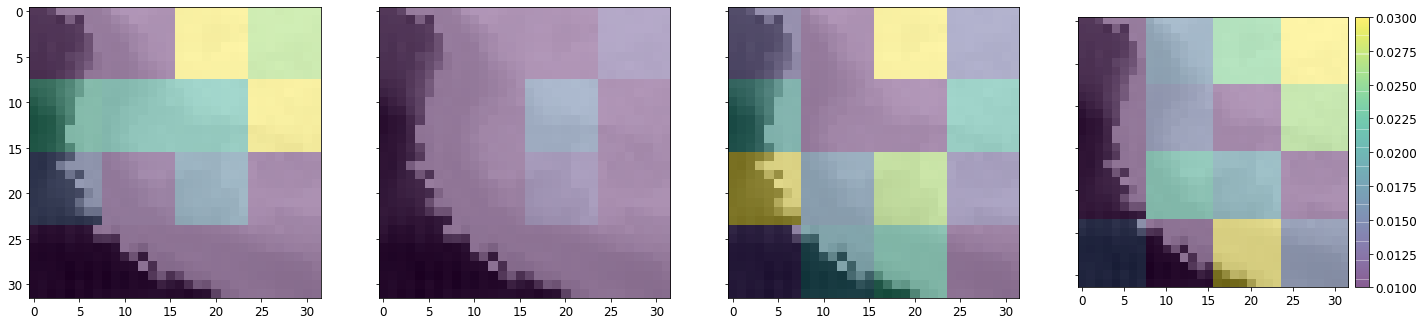

In [14]:
_ = engine.sp_att_map(df, input_maps, stt_att_out, global_case = None, local_date = '20150317_0000', threshold = 0.5)

Rank 1: Value = 0.01945515879197046, time_step = 1
Rank 2: Value = 0.016834000824019313, time_step = 3
Rank 3: Value = 0.015434954839292914, time_step = 2
Rank 4: Value = 0.009525144821964204, time_step = 0


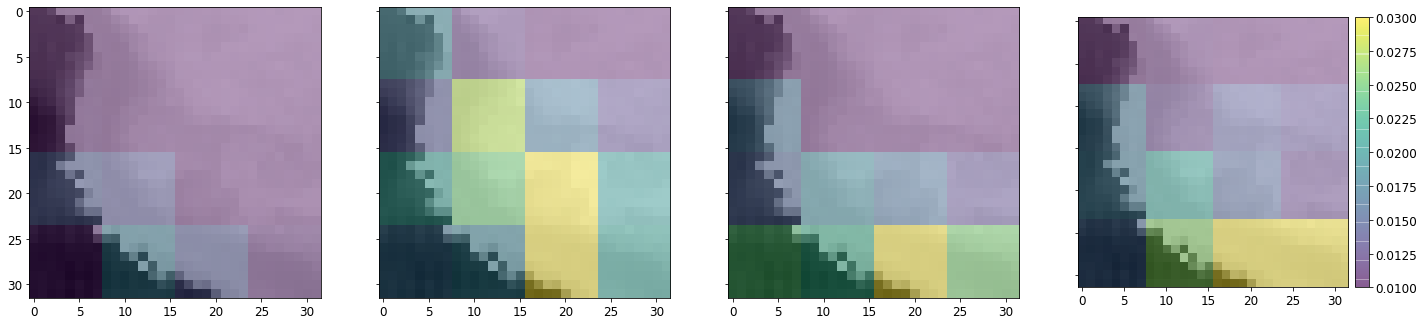

In [20]:
_ = engine.sp_att_map(df, input_maps, stt_att_out, global_case = 'Hit', local_date = None, threshold = 0.5)

Rank 1: Value = 0.019631315837614238, time_step = 2
Rank 2: Value = 0.01840624149190262, time_step = 1
Rank 3: Value = 0.013113046647049487, time_step = 3
Rank 4: Value = 0.010183985228650272, time_step = 0


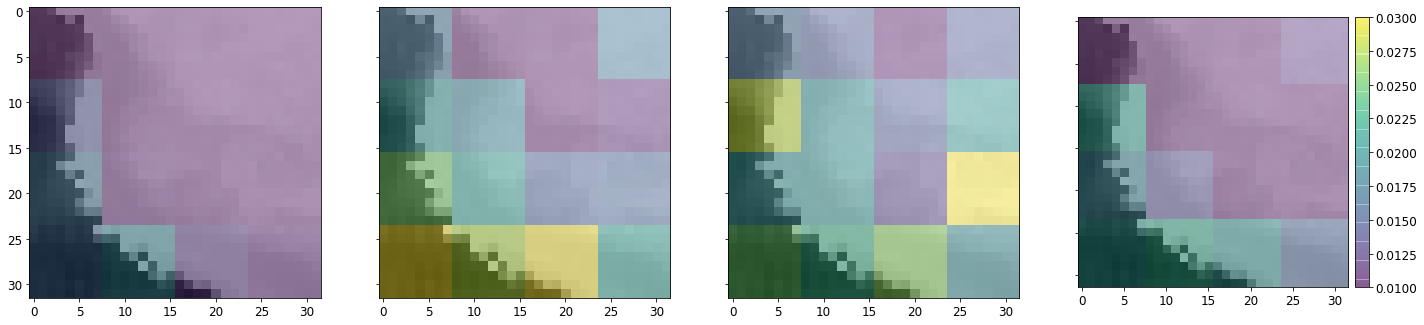

In [15]:
_ = engine.sp_att_map(df, input_maps, stt_att_out, global_case = 'Miss', local_date = None, threshold = 0.5)

Rank 1: Value = 0.01687511382624507, time_step = 3
Rank 2: Value = 0.01555080316029489, time_step = 2
Rank 3: Value = 0.014131766598438844, time_step = 0
Rank 4: Value = 0.013330024667084217, time_step = 1


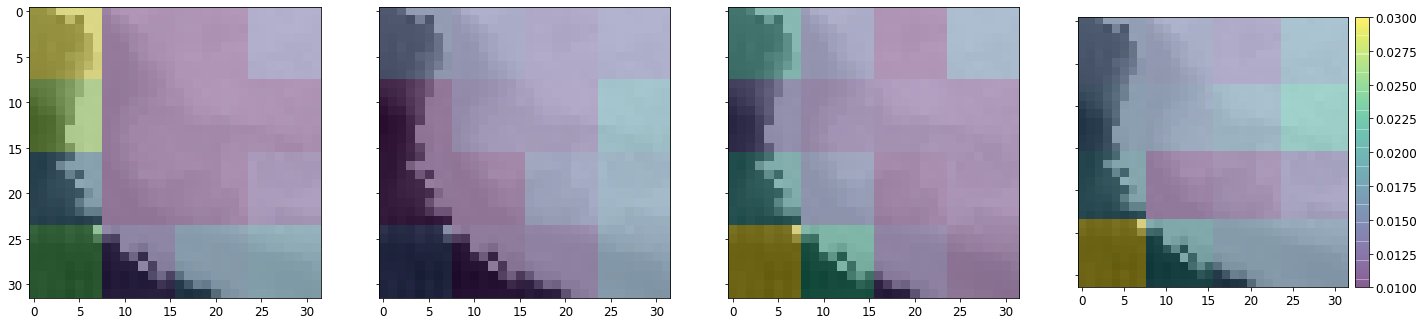

In [16]:
_ = engine.sp_att_map(df, input_maps, stt_att_out, global_case = 'FA', local_date = None, threshold = 0.5)

Rank 1: Value = 0.016062416427303106, time_step = 1
Rank 2: Value = 0.015484334668144584, time_step = 3
Rank 3: Value = 0.014996569021604955, time_step = 2
Rank 4: Value = 0.013627400097902864, time_step = 0


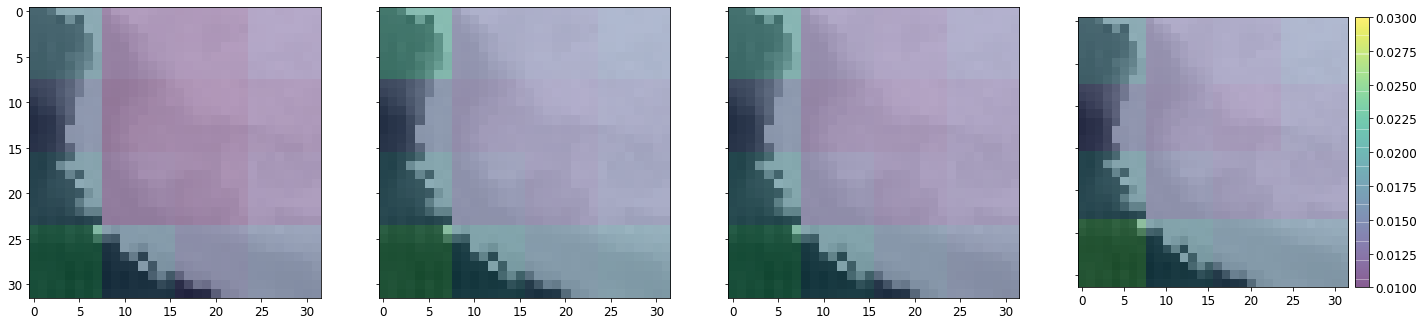

In [17]:
_ = engine.sp_att_map(df, input_maps, stt_att_out, global_case = 'CR', local_date = None, threshold = 0.5)